## 1-3 転移学習の実装

vggの転移学習で自前データ（今回はオープンのやつ）の画像分類モデルつくる  
  
### やること
- dataset作成 
- dataloader作成 (batchごとにデータ取り出す)
- 学習済みモデルの出力層の変更 (転移前とでデータ違う、クラス数も違う、ので)
- 出力層付近のパラメータだけ学習させる (特徴抽出はそのまま)

In [1]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

In [2]:
# 乱数設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

### Dataset作成
前処理するclassつくる  
train, val で処理変える（trainではランダムでdata augmentationしてみる）  

In [3]:
class ImageTransform():
    """
    resize: int or tuple
        リサイズ後のサイズ。tupleなら(h, w)。intなら短辺=resize,長辺はアスペクト比保つように変換。
        transforms.Resize()の実装参照。
    mean: (R, G, B)
        各チャネルの平均。
    std: (R, G, B)
        各チャネルの標準偏差。
    """
    def __init__(self, resize, mean, std):
        self.data_transform = {
            "train": transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)# input = (input - mean) / std
            ]),
            "val": transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
            
    def __call__(self, img, phase="train"):
        # train or val どちらかのComposeに画像渡して処理
        return self.data_transform[phase](img)

処理して見てみる  
(ランダムな処理あるので、実行ごとに結果異なる)

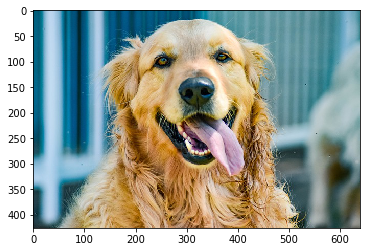

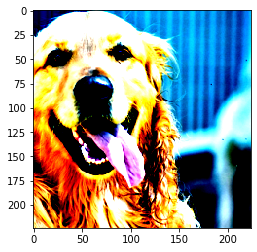

In [7]:
# 画像読み込み
img_path = "./data/goldenretriever-3724972_640.jpg"
img = Image.open(img_path)

# 元画像表示
plt.imshow(img)
plt.show()

# 前処理
size = 224#vggの入力サイズ
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")# torch.Size([3, 224, 224])

# (c, h, w) を(h, w, c) に変換、画素値を0-1に変換
# 処理後画像表示
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()